# 代码模块及细节

## 1 初始化

In [150]:
import argparse
import os
import numpy as np
import time
import datetime
import sys
import torch

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.autograd import Variable

In [151]:
parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="monet2photo", help="name of the dataset")
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_height", type=int, default=256, help="size of image height")
parser.add_argument("--img_width", type=int, default=256, help="size of image width")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between saving generator outputs")
parser.add_argument("--checkpoint_interval", type=int, default=-1, help="interval between saving model checkpoints")
parser.add_argument("--n_residual_blocks", type=int, default=9, help="number of residual blocks in generator")
parser.add_argument("--lambda_cyc", type=float, default=10.0, help="cycle loss weight")
parser.add_argument("--lambda_id", type=float, default=5.0, help="identity loss weight")
opt = parser.parse_known_args()[0]
print(opt)

Namespace(b1=0.5, b2=0.999, batch_size=1, channels=3, checkpoint_interval=-1, dataset_name='monet2photo', decay_epoch=100, epoch=0, img_height=256, img_width=256, lambda_cyc=10.0, lambda_id=5.0, lr=0.0002, n_cpu=0, n_epochs=200, n_residual_blocks=9, sample_interval=100)


In [152]:
# Create sample and checkpoint directories
os.makedirs("images/%s" % opt.dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % opt.dataset_name, exist_ok=True)
input_shape = (opt.channels, opt.img_height, opt.img_width)
print("input_shape =", input_shape)

input_shape = (3, 256, 256)


## 2 数据加载

加载的数据为 256*256 的莫奈绘画和风景照片     
     
RGB（红绿蓝）是最通用的面向硬件的彩色模型，可表示大部分颜色，但科学研究中一般不采用RGB颜色空间。   
CMY是工业印刷采用的颜色空间。RGB来源于物体的发光，而CMY是依据反射光得到的。它的具体应用如打印机：一般采用四色墨盒，即CMY加黑色墨盒。   
HSX颜色空间不适合显示器系统，但是更符合人眼的视觉特性。其中的X可能是V,也可能是I。H是色调，S是饱和度，V是亮度，I是强度。  
YUV是通过亮度-色差来描述颜色的颜色空间。亮度信号经常被称作Y，色度信号是由两个互相独立的信号组成。视颜色系统和格式不同，两种色度信号经常被称作UV或PbPr或CbCr。
       
       
![title](figures/2.png)
![title](figures/3.png)
![title](figures/4.png)

### 2.1 数据集类      

In [153]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [154]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_) if transforms_ is not None else None
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%s/A" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%s/B" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        if self.transform is not None:
            item_A = self.transform(image_A)
            item_B = self.transform(image_B)
        else:
            item_A = image_A
            item_B = image_B
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [155]:
# Image transformations
transforms_ = [
    transforms.Resize(int(opt.img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((opt.img_height, opt.img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
dataloader = DataLoader(
    ImageDataset("../../data/%s" % opt.dataset_name, transforms_=transforms_, unaligned=True),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset("../../data/%s" % opt.dataset_name, transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=5,
    shuffle=True,
    num_workers=opt.n_cpu,
)


### 2.2 分解演示      

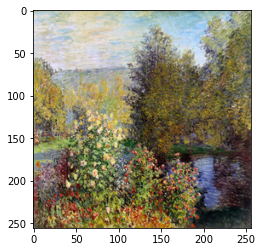

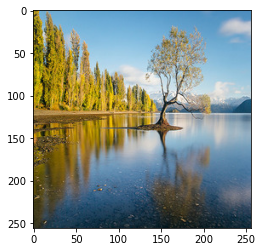

In [156]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

def show_img(img, trans=True):
    if trans:
        img = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))  # 把channel维度放到最后
        plt.imshow(img / 2 + 0.5)
    else:
        plt.imshow(img)
    plt.show()

# unaligned
photos = ImageDataset("../../data/%s" % opt.dataset_name, unaligned=True)
sample = photos[0]['A']
show_img(np.array(sample), trans=False)
sample = photos[0]['B']
show_img(np.array(sample), trans=False)

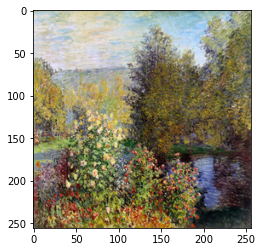

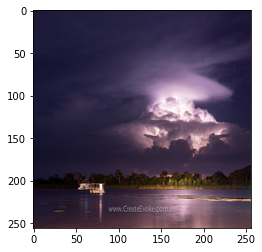

In [157]:
# aligned
photos = ImageDataset("../../data/%s" % opt.dataset_name, unaligned=False)
sample = photos[0]['A']
show_img(np.array(sample), trans=False)
sample = photos[0]['B']
show_img(np.array(sample), trans=False)

In [158]:
trans_resize = transforms.Resize(int(opt.img_height * 1.12), Image.BICUBIC)
trans_crop = transforms.RandomCrop((opt.img_height, opt.img_width))
trans_flip = transforms.RandomHorizontalFlip()
trans_to_tensor = transforms.ToTensor()
trans_normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # x_n = (x - 0.5) / 0.5

print("data =", np.array(sample), '\n')
print("shape =", np.array(sample).shape, '\n')
sample_resize = trans_resize(sample) 
print("(trans_resize) shape =", np.array(sample_resize).shape, '\n')
sample_crop = trans_crop(sample_resize) 
print("(trans_crop) shape =", np.array(sample_crop).shape, '\n')
sample_flip = trans_crop(sample_crop) 
print("(trans_flip) shape =", np.array(sample_flip).shape, '\n')
sample_tensor = trans_to_tensor(sample_flip)
print("(trans_to_tensor) data =", sample_tensor, '\n')
sample_normalize = trans_normalize(sample_tensor)
print("(trans_normalize) data =", sample_normalize, '\n')

data = [[[31 24 55]
  [32 26 54]
  [30 26 53]
  ...
  [29 20 49]
  [29 20 49]
  [28 19 48]]

 [[31 25 53]
  [32 26 54]
  [30 26 53]
  ...
  [29 20 49]
  [29 20 49]
  [28 19 48]]

 [[31 25 53]
  [31 25 53]
  [29 25 52]
  ...
  [30 21 50]
  [30 21 50]
  [29 20 49]]

 ...

 [[41 28 38]
  [44 24 35]
  [50 29 38]
  ...
  [89 61 60]
  [89 61 60]
  [89 61 60]]

 [[57 31 42]
  [56 33 43]
  [56 33 43]
  ...
  [93 63 63]
  [90 60 60]
  [90 62 61]]

 [[53 27 36]
  [51 25 34]
  [53 27 36]
  ...
  [95 64 62]
  [89 59 59]
  [90 60 62]]] 

shape = (256, 256, 3) 

(trans_resize) shape = (286, 286, 3) 

(trans_crop) shape = (256, 256, 3) 

(trans_flip) shape = (256, 256, 3) 

(trans_to_tensor) data = tensor([[[0.1176, 0.1176, 0.1176,  ..., 0.1176, 0.1216, 0.1176],
         [0.1216, 0.1176, 0.1176,  ..., 0.1216, 0.1176, 0.1176],
         [0.1137, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         ...,
         [0.1137, 0.1137, 0.1137,  ..., 0.3412, 0.3412, 0.3333],
         [0.1176, 0.1176, 0.1176,

### 2.3 数据缓存

In [159]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            # 队列没存满时，把element进行入队和返回
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            # 队列存满后，50%的概率直接返回element，50%的概率随机返回队列中的一个数据，并在队列中使用element将其代替
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
            print("push_and_pop data:", self.data, "   return:", to_return)
        return Variable(torch.cat(to_return))
    
# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [160]:
test_buffer = ReplayBuffer(2)
data = torch.Tensor([i for i in range(5)])
print(test_buffer.push_and_pop(data))

push_and_pop data: [tensor([0.])]    return: [tensor([0.])]
push_and_pop data: [tensor([0.]), tensor([1.])]    return: [tensor([0.]), tensor([1.])]
push_and_pop data: [tensor([0.]), tensor([1.])]    return: [tensor([0.]), tensor([1.]), tensor([2.])]
push_and_pop data: [tensor([3.]), tensor([1.])]    return: [tensor([0.]), tensor([1.]), tensor([2.]), tensor([0.])]
push_and_pop data: [tensor([3.]), tensor([1.])]    return: [tensor([0.]), tensor([1.]), tensor([2.]), tensor([0.]), tensor([4.])]
tensor([0., 1., 2., 0., 4.])


## 3 模型
### 3.1生成器
包含2个下采样block、9个Resblock 和 2个上采样block，block中使用ReLU激活函数，使用了InstanceNorm和ReflectionPad2d，使用nearest resize进行上采样、跨步卷积进行下采样   
    
PyTorch中的pad方式：   
ZeroPad2d，ConstantPad2d，ReplicationPad2，ReflectionPad2   
              
ReplicationPad2d：重复图像的边缘像素值 
ReflectionPad2d：使用反方向的边缘像素值    

![title](figures/5.png)
![title](figures/7.png)
![title](figures/6.png)

In [161]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [162]:
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    
G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, opt.n_residual_blocks)
print(G_AB)

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256

### 3.2判别器
包含4个下采样block和1个卷积层，block中使用LeakyReLU激活函数，使用了InstanceNorm，使用跨步卷积进行下采样    

In [163]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)
print(D_A)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


### 3.3初始化    
加载已有模型，或者对卷积层和BatchNorm层进行参数初始化

In [164]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

if opt.epoch != 0:
    # Load pretrained models
    G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (opt.dataset_name, opt.epoch)))
    G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (opt.dataset_name, opt.epoch)))
    D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (opt.dataset_name, opt.epoch)))
    D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (opt.dataset_name, opt.epoch)))
else:
    # Initialize weights
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

## 4 损失函数
使用 MSE loss 和 L1 loss    

In [165]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

## 5 Cuda加速

In [166]:
cuda = True if torch.cuda.is_available() else False
print("cuda_is_available =", cuda)
if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

cuda_is_available = True


## 6 优化器
使用Adam优化器

In [167]:
import itertools

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))


# 自定义的LR衰减比率
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)

print("opt.lr = ", opt.lr)
print("opt.n_epochs = %d, opt.epoch = %d, opt.decay_epoch = %d" %(opt.n_epochs, opt.epoch, opt.decay_epoch))
print("lr_scheduler_G.lr =", lr_scheduler_G.get_lr())

opt.lr =  0.0002
opt.n_epochs = 200, opt.epoch = 0, opt.decay_epoch = 100
lr_scheduler_G.lr = [0.0002]


## 7 创建输入
分别从数据集和随机向量中获取输入

{'A': tensor([[[[-0.2235, -0.2784, -0.1216,  ..., -0.1059, -0.0275, -0.1059],
          [-0.2627, -0.2706, -0.1922,  ..., -0.0039, -0.3333, -0.5608],
          [-0.0980, -0.1373, -0.1922,  ...,  0.2706, -0.0745, -0.2549],
          ...,
          [ 0.1608,  0.1922,  0.2000,  ..., -0.1294, -0.0745, -0.2000],
          [ 0.1686,  0.1922,  0.2235,  ..., -0.0118,  0.0039, -0.2627],
          [ 0.2392,  0.2627,  0.2078,  ..., -0.3255, -0.2235, -0.3255]],

         [[-0.2863, -0.3490, -0.1686,  ...,  0.0510,  0.1294,  0.0431],
          [-0.3176, -0.3255, -0.2392,  ...,  0.1529, -0.1686, -0.4039],
          [-0.1686, -0.1843, -0.2471,  ...,  0.4196,  0.0745, -0.1216],
          ...,
          [ 0.0902,  0.1137,  0.1216,  ..., -0.2000, -0.1137, -0.1686],
          [ 0.0902,  0.0980,  0.1373,  ..., -0.0824, -0.0275, -0.2157],
          [ 0.1529,  0.1686,  0.1216,  ..., -0.3098, -0.1686, -0.2157]],

         [[-0.5529, -0.6078, -0.4196,  ..., -0.0353,  0.0510, -0.0196],
          [-0.6000, -0.5

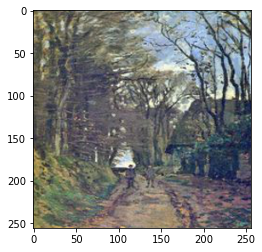

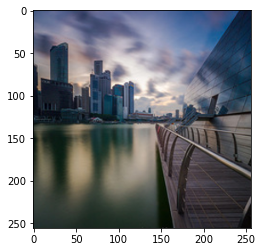

In [168]:
epoch = 0
prev_time = time.time()
print(dataloader)

i, batch = next(enumerate(dataloader))

# Set model input
print(batch)
real_A = Variable(batch["A"].type(Tensor))
real_B = Variable(batch["B"].type(Tensor))

# Adversarial ground truths
valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

print("shape of real_A =", real_A.shape, '\n')
print("shape of real_B =", real_B.shape, '\n')
print("real_imgs =")
show_img(real_A[0])
show_img(real_B[0])

## 8 计算loss，反向传播
分别对生成器和判别器计算loss，使用反向传播更新模型参数

### 8.1 训练生成器 

In [169]:
G_AB.train()
G_BA.train()

optimizer_G.zero_grad()

# Identity loss
loss_id_A = criterion_identity(G_BA(real_A), real_A)
loss_id_B = criterion_identity(G_AB(real_B), real_B)

loss_identity = (loss_id_A + loss_id_B) / 2
print("loss_identity =", loss_identity)

# GAN loss
fake_B = G_AB(real_A)
loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
fake_A = G_BA(real_B)
loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
print("loss_GAN =", loss_GAN)

# Cycle loss
recov_A = G_BA(fake_B)
loss_cycle_A = criterion_cycle(recov_A, real_A)
recov_B = G_AB(fake_A)
loss_cycle_B = criterion_cycle(recov_B, real_B)

loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
print("loss_cycle =", loss_cycle)

# Total loss
loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity
print("opt.lambda_cyc = %d   opt.lambda_id = %d " % (opt.lambda_cyc, opt.lambda_id))
print("loss_G =", loss_G)

loss_G.backward()
optimizer_G.step()

loss_identity = tensor(0.5551, device='cuda:0', grad_fn=<DivBackward0>)
loss_GAN = tensor(2.1588, device='cuda:0', grad_fn=<DivBackward0>)
loss_cycle = tensor(0.5740, device='cuda:0', grad_fn=<DivBackward0>)
opt.lambda_cyc = 10   opt.lambda_id = 5 
loss_G = tensor(10.6740, device='cuda:0', grad_fn=<AddBackward0>)


### 8.2 训练判别器 

In [170]:
# -----------------------
#  Train Discriminator A
# -----------------------

optimizer_D_A.zero_grad()

# Real loss
loss_real = criterion_GAN(D_A(real_A), valid)
# Fake loss (on batch of previously generated samples)
fake_A_ = fake_A_buffer.push_and_pop(fake_A)
loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
# Total loss
loss_D_A = (loss_real + loss_fake) / 2
print("------ Discriminator A ------")
print("loss_real =", loss_real)
print("loss_fake =", loss_fake)

loss_D_A.backward()
optimizer_D_A.step()

# -----------------------
#  Train Discriminator B
# -----------------------

optimizer_D_B.zero_grad()

# Real loss
loss_real = criterion_GAN(D_B(real_B), valid)
# Fake loss (on batch of previously generated samples)
fake_B_ = fake_B_buffer.push_and_pop(fake_B)
loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
# Total loss
loss_D_B = (loss_real + loss_fake) / 2
print("------ Discriminator B ------")
print("loss_real =", loss_real)
print("loss_fake =", loss_fake)

loss_D_B.backward()
optimizer_D_B.step()

loss_D = (loss_D_A + loss_D_B) / 2

push_and_pop data: [tensor([[[[ 6.3908e-02, -4.0388e-01, -1.6462e-01,  ..., -1.5690e-01,
            3.8997e-01,  3.2682e-01],
          [ 2.3471e-01, -2.6724e-02,  1.4287e-01,  ...,  2.4490e-01,
            1.9592e-01,  1.3859e-01],
          [ 2.9185e-01,  1.4218e-02,  2.9269e-01,  ...,  3.7275e-01,
            3.6404e-01,  5.9063e-01],
          ...,
          [-3.7734e-01, -2.5173e-01,  1.8254e-01,  ..., -6.4426e-01,
           -7.8742e-01, -7.6434e-01],
          [-3.2672e-01, -1.9155e-01,  1.2675e-01,  ..., -5.6200e-01,
           -4.6046e-01, -5.2307e-01],
          [-2.9130e-01, -1.5547e-01,  7.1940e-02,  ..., -2.3323e-01,
           -5.0266e-01, -1.6914e-01]],

         [[ 2.7155e-01,  3.7458e-01,  3.3813e-01,  ..., -1.2233e-01,
           -5.7782e-01, -3.2577e-01],
          [-6.2565e-02, -5.5149e-02, -7.8623e-02,  ..., -6.0466e-01,
           -7.6347e-01, -6.4981e-01],
          [ 7.4807e-02,  1.6642e-01,  7.3521e-02,  ..., -3.2886e-01,
           -4.4920e-01, -9.6896e-02],


## 9 训练输出与模型保存

In [171]:
# Determine approximate time left
batches_done = epoch * len(dataloader) + i
batches_left = opt.n_epochs * len(dataloader) - batches_done
time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
prev_time = time.time()

# Print log
sys.stdout.write(
    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
    % (
        epoch,
        opt.n_epochs,
        i,
        len(dataloader),
        loss_D.item(),
        loss_G.item(),
        loss_GAN.item(),
        loss_cycle.item(),
        loss_identity.item(),
        time_left,
    )
)

[Epoch 0/200] [Batch 0/6287] [D loss: 1.684526] [G loss: 10.674042, adv: 2.158820, cycle: 0.573995, identity: 0.555055] ETA: 113 days, 16:36:17.026367

In [175]:
# Update learning rates
lr_scheduler_G.step()
lr_scheduler_D_A.step()
lr_scheduler_D_B.step()
print("lr_scheduler_G.lr =", lr_scheduler_G.get_lr())
print("lr_scheduler_D_A.lr =", lr_scheduler_D_A.get_lr())
print("lr_scheduler_D_B.lr =", lr_scheduler_D_B.get_lr())
for i in range(105):
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
print("lr_scheduler_G.lr =", lr_scheduler_G.get_lr())
print("lr_scheduler_D_A.lr =", lr_scheduler_D_A.get_lr())
print("lr_scheduler_D_B.lr =", lr_scheduler_D_B.get_lr())

if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
    # Save model checkpoints
    torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (opt.dataset_name, epoch))
    torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (opt.dataset_name, epoch))
    torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (opt.dataset_name, epoch))
    torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (opt.dataset_name, epoch))

lr_scheduler_G.lr = [0.0002]
lr_scheduler_D_A.lr = [0.0002]
lr_scheduler_D_B.lr = [0.0002]
lr_scheduler_G.lr = [0.00019]
lr_scheduler_D_A.lr = [0.00019]
lr_scheduler_D_B.lr = [0.00019]
